In [10]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

df_train_1 = pd.read_csv('C:/Users/User/Downloads/WQD7002 Data Science Research Project/datasets/same_months/testing/test/output_test/run0901/test_dataset_COVID_pt_train_validate.csv')
columntodrop = ['pt', 'steps', 'Mean', 'Max', 'Oxygen level (SpO2)']
df_train_1 = df_train_1.drop(columntodrop, axis=1)

# Separate features (X) and target variable (y) for training dataset
X_train = df_train_1.drop('Neuropsychiatric symptoms-new', axis=1)
y_train = df_train_1['Neuropsychiatric symptoms-new']

# Replace 'test_dataset.csv' with the actual name of your testing dataset
df_val = pd.read_csv('C:/Users/User/Downloads/WQD7002 Data Science Research Project/datasets/same_months/testing/test/output_test/run0901/test_dataset_COVID_pt_val.csv')
columntodrop1 = ['pt', 'steps', 'Mean', 'Max', 'Oxygen level (SpO2)']
df_val = df_val.drop(columntodrop1, axis=1)

# Separate features (X) and target variable (y) for testing dataset
X_val = df_val.drop('Neuropsychiatric symptoms-new', axis=1)
y_val = df_val['Neuropsychiatric symptoms-new']

# Normalizing data so that all variables follow the same scale (0 to 1)
scaler = MinMaxScaler()

# Fit only to the training data
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [65]:
column_names = ['Median', 'Mode', ' Min', 'deepSleepTime (hours)', 'REMTime (hours)','shallowSleepTime (hours)']

# Apply SMOTE to generate synthetic samples
smote = SMOTE(random_state=11)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Create a new DataFrame with the resampled data
df_resampled_1 = pd.concat([pd.DataFrame(X_resampled, columns=column_names), pd.Series(y_resampled, name='Neuropsychiatric symptoms-new')], axis=1)

# Display the count of each class after oversampling
print("Class distribution after oversampling:")
print(df_resampled_1['Neuropsychiatric symptoms-new'].value_counts())

# Save the oversampled dataset to a new CSV file
df_resampled_1.to_csv('oversampled_normalized_ML_retrain_COVID_train_1.csv', index=False)

Class distribution after oversampling:
0    245
1    245
Name: Neuropsychiatric symptoms-new, dtype: int64


In [66]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

# Load your data from a CSV file
df_resampled_train_1 = pd.read_csv('C:/Users/User/Downloads/WQD7002 Data Science Research Project/datasets/same_months/testing/test/output_test/run0901/oversampled_normalized_ML_retrain_COVID_train_1.csv')

# Separate features (X) and target variable (y) for training dataset
X_train = df_resampled_train_1.drop('Neuropsychiatric symptoms-new', axis=1)
y_train = df_resampled_train_1['Neuropsychiatric symptoms-new']

# Initialize individual classifiers
rf_classifier = RandomForestClassifier(random_state=14, max_features=7)
xgb_classifier = XGBClassifier(random_state=14)
logreg_classifier = LogisticRegression(random_state=14)
voting_classifier = VotingClassifier(estimators=[
    ('random_forest', rf_classifier),
    ('xgboost', xgb_classifier),
    ('logistic_regression', logreg_classifier)
], voting='hard')  # 'hard' means majority voting, you can also use 'soft' for weighted voting

# List of models and their names
models = [rf_classifier, xgb_classifier, logreg_classifier, voting_classifier]
model_names = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Voting Classifier']

# Step 4: Combine oversampled data and perform 6-fold cross-validation for each model
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=16)

# Using F1 score as the scoring metric
f1_scores = []

for model, name in zip(models, model_names):
    f1_scorer = make_scorer(f1_score)
    cross_val_results = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_scorer)
    mean_f1_score = cross_val_results.mean()
    f1_scores.append((name, mean_f1_score))

# Sort and print F1 scores in descending order
sorted_f1_scores = sorted(f1_scores, key=lambda x: x[1], reverse=True)
print("\nSorted F1 Scores:")
for name, mean_f1_score in sorted_f1_scores:
    print(f'Model: {name}, Mean Cross-Validation F1 Score: {mean_f1_score}')

# Choose the best model based on the highest F1 score
best_model_name, best_model_f1 = sorted_f1_scores[0]
print(f"\nBest Model: {best_model_name}, Mean Cross-Validation F1 Score: {best_model_f1}")

# Lists to store validation F1 scores and accuracy scores
validation_f1_scores = []
validation_accuracy_scores = []

for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    validation_f1_scores.append((name, f1))
    validation_accuracy_scores.append((name, accuracy))

# Sort and print Validation F1 scores in descending order
sorted_validation_f1_scores = sorted(validation_f1_scores, key=lambda x: x[1], reverse=True)
print("\nSorted Validation F1 Scores:")
for name, f1_score in sorted_validation_f1_scores:
    print(f'Model: {name}, Validation F1 Score: {f1_score}')

# Sort and print Validation accuracy scores in descending order
sorted_validation_accuracy_scores = sorted(validation_accuracy_scores, key=lambda x: x[1], reverse=True)
print("\nSorted Validation Accuracy Scores:")
for name, accuracy_score in sorted_validation_accuracy_scores:
    print(f'Model: {name}, Validation Accuracy Score: {accuracy_score}')

# Choose the best model based on the highest Validation F1 score
best_model_name, best_model_f1 = sorted_validation_f1_scores[0]
print(f"\nBest Model (Validation F1): {best_model_name}, Validation F1 Score: {best_model_f1}")

# Choose the best model based on the highest Validation accuracy score
best_model_name_acc, best_model_acc = sorted_validation_accuracy_scores[0]
print(f"Best Model (Validation Accuracy): {best_model_name_acc}, Validation Accuracy Score: {best_model_acc}")


Sorted F1 Scores:
Model: Random Forest, Mean Cross-Validation F1 Score: 0.8967580310085473
Model: Voting Classifier, Mean Cross-Validation F1 Score: 0.8928470958227558
Model: XGBoost, Mean Cross-Validation F1 Score: 0.8914916379267454
Model: Logistic Regression, Mean Cross-Validation F1 Score: 0.6598324106597888

Best Model: Random Forest, Mean Cross-Validation F1 Score: 0.8967580310085473

Sorted Validation F1 Scores:
Model: Logistic Regression, Validation F1 Score: 0.4166666666666667
Model: XGBoost, Validation F1 Score: 0.2580645161290323
Model: Voting Classifier, Validation F1 Score: 0.2424242424242424
Model: Random Forest, Validation F1 Score: 0.12903225806451615

Sorted Validation Accuracy Scores:
Model: XGBoost, Validation Accuracy Score: 0.8083333333333333
Model: Voting Classifier, Validation Accuracy Score: 0.7916666666666666
Model: Random Forest, Validation Accuracy Score: 0.775
Model: Logistic Regression, Validation Accuracy Score: 0.65

Best Model (Validation F1): Logistic 

In [28]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

# Load your data from a CSV file
df_resampled_train_1 = pd.read_csv('C:/Users/User/Downloads/WQD7002 Data Science Research Project/datasets/same_months/testing/test/output_test/run0901/oversampled_normalized_ML_retrain_COVID_train_1.csv')

# Separate features (X) and target variable (y) for the training dataset
X_train = df_resampled_train_1.drop('Neuropsychiatric symptoms-new', axis=1)
y_train = df_resampled_train_1['Neuropsychiatric symptoms-new']

# Initialize individual classifiers
rf_classifier = RandomForestClassifier(random_state=14, max_features=7)
xgb_classifier = XGBClassifier(random_state=14)
logreg_classifier = LogisticRegression(random_state=14)
voting_classifier = VotingClassifier(estimators=[
    ('random_forest', rf_classifier),
    ('xgboost', xgb_classifier),
    ('logistic_regression', logreg_classifier)
], voting='soft')  # 'hard' means majority voting, you can also use 'soft' for weighted voting

# List of models and their names
models = [rf_classifier, xgb_classifier, logreg_classifier, voting_classifier]
model_names = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Voting Classifier']

# Step 4: Combine oversampled data and perform 6-fold cross-validation for each model
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=16)

# Using F1 score, AUC-ROC, and AUC-PR as the scoring metrics
results_df = pd.DataFrame(columns=['Model', 'Mean F1 Score', 'Mean AUC-ROC', 'Mean AUC-PR'])

for model, name in zip(models, model_names):
    f1_scorer = make_scorer(f1_score)
    auc_roc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    auc_pr_scorer = make_scorer(average_precision_score, needs_proba=True)
    
    # F1 score
    cross_val_results_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_scorer)
    mean_f1_score = cross_val_results_f1.mean()
    
    # AUC-ROC
    cross_val_results_roc = cross_val_score(model, X_train, y_train, cv=cv, scoring=auc_roc_scorer)
    mean_auc_roc = cross_val_results_roc.mean()
    
    # AUC-PR
    cross_val_results_pr = cross_val_score(model, X_train, y_train, cv=cv, scoring=auc_pr_scorer)
    mean_auc_pr = cross_val_results_pr.mean()

    results_df = results_df.append({'Model': name, 'Mean F1 Score': mean_f1_score, 'Mean AUC-ROC': mean_auc_roc, 'Mean AUC-PR': mean_auc_pr}, ignore_index=True)

# Print results
print("\nCross-Validation Results:")
print(results_df)

# Choose the best model based on the highest mean F1 score
best_model_name, best_model_f1 = results_df.sort_values(by='Mean F1 Score', ascending=False).iloc[0, :2]
print(f"\nBest Model (F1): {best_model_name}, Mean F1 Score: {best_model_f1}")

# Choose the best model based on the highest mean AUC-ROC score
best_model_name_roc, best_model_roc = results_df.sort_values(by='Mean AUC-ROC', ascending=False).iloc[0, [0, 2]]
print(f"Best Model (AUC-ROC): {best_model_name_roc}, Mean AUC-ROC: {best_model_roc}")

# Choose the best model based on the highest mean AUC-PR score
best_model_name_pr, best_model_pr = results_df.sort_values(by='Mean AUC-PR', ascending=False).iloc[0, [0, 3]]
print(f"Best Model (AUC-PR): {best_model_name_pr}, Mean AUC-PR: {best_model_pr}")

# Lists to store validation F1 scores, accuracy scores, AUC-ROC, and AUC-PR scores
validation_f1_scores = []
validation_accuracy_scores = []
validation_auc_roc_scores = []
validation_auc_pr_scores = []

for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]
    
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_roc = roc_auc_score(y_val, y_prob)
    auc_pr = average_precision_score(y_val, y_prob)
    
    validation_f1_scores.append((name, f1))
    validation_accuracy_scores.append((name, accuracy))
    validation_auc_roc_scores.append((name, auc_roc))
    validation_auc_pr_scores.append((name, auc_pr))

# Sort and print Validation F1 scores in descending order
sorted_validation_f1_scores = sorted(validation_f1_scores, key=lambda x: x[1], reverse=True)
print("\nSorted Validation F1 Scores:")
for name, f1_score in sorted_validation_f1_scores:
    print(f'Model: {name}, Validation F1 Score: {f1_score}')

# Sort and print Validation accuracy scores in descending order
sorted_validation_accuracy_scores = sorted(validation_accuracy_scores, key=lambda x: x[1], reverse=True)
print("\nSorted Validation Accuracy Scores:")
for name, accuracy_score in sorted_validation_accuracy_scores:
    print(f'Model: {name}, Validation Accuracy Score: {accuracy_score}')

# Sort and print Validation AUC-ROC scores in descending order
sorted_validation_auc_roc_scores = sorted(validation_auc_roc_scores, key=lambda x: x[1], reverse=True)
print("\nSorted Validation AUC-ROC Scores:")
for name, auc_roc_score in sorted_validation_auc_roc_scores:
    print(f'Model: {name}, Validation AUC-ROC Score: {auc_roc_score}')

# Sort and print Validation AUC-PR scores in descending order
sorted_validation_auc_pr_scores = sorted(validation_auc_pr_scores, key=lambda x: x[1], reverse=True)
print("\nSorted Validation AUC-PR Scores:")
for name, auc_pr_score in sorted_validation_auc_pr_scores:
    print(f'Model: {name}, Validation AUC-PR Score: {auc_pr_score}')



Cross-Validation Results:
                 Model  Mean F1 Score  Mean AUC-ROC  Mean AUC-PR
0        Random Forest       0.896758      0.953190     0.953088
1              XGBoost       0.891492      0.955461     0.956283
2  Logistic Regression       0.659832      0.739193     0.771068
3    Voting Classifier       0.887955      0.949398     0.951075

Best Model (F1): Random Forest, Mean F1 Score: 0.8967580310085473
Best Model (AUC-ROC): XGBoost, Mean AUC-ROC: 0.9554605393614913
Best Model (AUC-PR): XGBoost, Mean AUC-PR: 0.9562832515923155

Sorted Validation F1 Scores:
Model: Logistic Regression, Validation F1 Score: 0.4166666666666667
Model: XGBoost, Validation F1 Score: 0.2580645161290323
Model: Voting Classifier, Validation F1 Score: 0.2424242424242424
Model: Random Forest, Validation F1 Score: 0.12903225806451615

Sorted Validation Accuracy Scores:
Model: XGBoost, Validation Accuracy Score: 0.8083333333333333
Model: Voting Classifier, Validation Accuracy Score: 0.7916666666666666
Mo

In [18]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Load your data from a CSV file
df_resampled_train_1 = pd.read_csv('C:/Users/User/Downloads/WQD7002 Data Science Research Project/datasets/same_months/testing/test/output_test/run0901/oversampled_normalized_ML_retrain_COVID_train_1.csv')

# Separate features (X) and target variable (y) for training dataset
X_train = df_resampled_train_1.drop('Neuropsychiatric symptoms-new', axis=1)
y_train = df_resampled_train_1['Neuropsychiatric symptoms-new']

# Define class weights (you can adjust these values based on your dataset characteristics)
class_weights = {0: 1, 1: 3}  # Assign higher weight to the minority class

# Initialize individual classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=14, class_weight=class_weights)
xgb_classifier = XGBClassifier(random_state=14, scale_pos_weight=class_weights[1])  # XGBoost uses `scale_pos_weight` for class weights)
logreg_classifier = LogisticRegression(random_state=14, class_weight=class_weights)
voting_classifier = VotingClassifier(estimators=[
    ('random_forest', rf_classifier),
    ('xgboost', xgb_classifier),
    ('logistic_regression', logreg_classifier)
], voting='soft')  # 'hard' means majority voting, you can also use 'soft' for weighted voting

# List of models and their names
models = [rf_classifier, xgb_classifier, logreg_classifier, voting_classifier]
model_names = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Voting Classifier']

# Step 4: Combine oversampled data and perform 5-fold cross-validation for each model
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=16)

# Using F1 score as the scoring metric
f1_scores_cv = []

for model, name in zip(models, model_names):
    f1_scorer = make_scorer(f1_score)
    cross_val_results = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_scorer)
    mean_f1_score = cross_val_results.mean()
    f1_scores_cv.append((name, mean_f1_score))

# Sort and print F1 scores in descending order after cross-validation
sorted_f1_scores_cv = sorted(f1_scores_cv, key=lambda x: x[1], reverse=True)
print("\nSorted F1 Scores after Cross-Validation:")
for name, mean_f1_score in sorted_f1_scores_cv:
    print(f'Model: {name}, Mean Cross-Validation F1 Score: {mean_f1_score}')

# Step 5: Train each model on the entire oversampled training set, test on validation set, and tune class weights/threshold
f1_scores_val = []

for model, name in zip(models, model_names):
    # Train the model on the entire oversampled training set
    model.fit(X_train, y_train)
    
    # Predict probabilities on the validation set
    y_prob_val = model.predict_proba(X_val)[:, 1]
    
    # Set a custom threshold 
    custom_threshold = 0.1
    
    # Convert probabilities to binary predictions based on the custom threshold
    y_pred_val_custom = (y_prob_val > custom_threshold).astype(int)
    
    # Evaluate the model with the custom threshold
    f1_val = f1_score(y_val, y_pred_val_custom)
    
    print(f'Model: {name}, Validation F1 Score with Custom Threshold: {f1_val}')
    
    f1_scores_val.append((name, f1_val))

# Sort and print F1 scores on the validation set in descending order
sorted_f1_scores_val = sorted(f1_scores_val, key=lambda x: x[1], reverse=True)
print("\nSorted F1 Scores on Validation Set:")
for name, f1_val in sorted_f1_scores_val:
    print(f'Model: {name}, Validation F1 Score: {f1_val}')



Sorted F1 Scores after Cross-Validation:
Model: Random Forest, Mean Cross-Validation F1 Score: 0.8897551090587944
Model: Voting Classifier, Mean Cross-Validation F1 Score: 0.8863980211836971
Model: XGBoost, Mean Cross-Validation F1 Score: 0.8860285540498886
Model: Logistic Regression, Mean Cross-Validation F1 Score: 0.6870693149928533
Model: Random Forest, Validation F1 Score with Custom Threshold: 0.30357142857142855
Model: XGBoost, Validation F1 Score with Custom Threshold: 0.39080459770114945
Model: Logistic Regression, Validation F1 Score with Custom Threshold: 0.2608695652173913
Model: Voting Classifier, Validation F1 Score with Custom Threshold: 0.2608695652173913

Sorted F1 Scores on Validation Set:
Model: XGBoost, Validation F1 Score: 0.39080459770114945
Model: Random Forest, Validation F1 Score: 0.30357142857142855
Model: Logistic Regression, Validation F1 Score: 0.2608695652173913
Model: Voting Classifier, Validation F1 Score: 0.2608695652173913


In [29]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Load your data from a CSV file
df_resampled_train_1 = pd.read_csv('C:/Users/User/Downloads/WQD7002 Data Science Research Project/datasets/same_months/testing/test/output_test/run0901/oversampled_normalized_ML_retrain_COVID_train_1.csv')

# Separate features (X) and target variable (y) for training dataset
X_train = df_resampled_train_1.drop('Neuropsychiatric symptoms-new', axis=1)
y_train = df_resampled_train_1['Neuropsychiatric symptoms-new']

# Define class weights (you can adjust these values based on your dataset characteristics)
class_weights = {0: 1, 1: 3}  # Assign higher weight to the minority class

# Initialize individual classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=14, class_weight=class_weights)
xgb_classifier = XGBClassifier(random_state=14, scale_pos_weight=class_weights[1])  # XGBoost uses `scale_pos_weight` for class weights)
logreg_classifier = LogisticRegression(random_state=14, class_weight=class_weights)
voting_classifier = VotingClassifier(estimators=[
    ('random_forest', rf_classifier),
    ('xgboost', xgb_classifier),
    ('logistic_regression', logreg_classifier)
], voting='soft')  # 'hard' means majority voting, you can also use 'soft' for weighted voting

# List of models and their names
models = [rf_classifier, xgb_classifier, logreg_classifier, voting_classifier]
model_names = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Voting Classifier']

# Step 4: Combine oversampled data and perform 5-fold cross-validation for each model
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=16)

# Using F1 score, AUC-ROC, and AUC-PR as the scoring metrics
results_df = pd.DataFrame(columns=['Model', 'Mean F1 Score', 'Mean AUC-ROC', 'Mean AUC-PR'])

for model, name in zip(models, model_names):
    f1_scorer = make_scorer(f1_score)
    auc_roc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    auc_pr_scorer = make_scorer(average_precision_score, needs_proba=True)
    
    # F1 score
    cross_val_results_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_scorer)
    mean_f1_score = cross_val_results_f1.mean()
    
    # AUC-ROC
    cross_val_results_roc = cross_val_score(model, X_train, y_train, cv=cv, scoring=auc_roc_scorer)
    mean_auc_roc = cross_val_results_roc.mean()
    
    # AUC-PR
    cross_val_results_pr = cross_val_score(model, X_train, y_train, cv=cv, scoring=auc_pr_scorer)
    mean_auc_pr = cross_val_results_pr.mean()

    results_df = results_df.append({'Model': name, 'Mean F1 Score': mean_f1_score, 'Mean AUC-ROC': mean_auc_roc, 'Mean AUC-PR': mean_auc_pr}, ignore_index=True)

# Print results
print("\nCross-Validation Results:")
print(results_df)

# Step 5: Train each model on the entire oversampled training set and test on the validation set
results_val_df = pd.DataFrame(columns=['Model', 'Validation F1 Score', 'AUC-ROC', 'AUC-PR'])

for model, name in zip(models, model_names):
    # Train the model on the entire oversampled training set
    model.fit(X_train, y_train)
    
    # Predict probabilities on the validation set
    y_prob_val = model.predict_proba(X_val)[:, 1]
    
    # Set a custom threshold 
    custom_threshold = 0.1
    
    # Convert probabilities to binary predictions based on the custom threshold
    y_pred_val_custom = (y_prob_val > custom_threshold).astype(int)
    
    # Evaluate the model with the custom threshold
    f1_val = f1_score(y_val, y_pred_val_custom)
    auc_roc_val_value = roc_auc_score(y_val, y_prob_val)
    auc_pr_val_value = average_precision_score(y_val, y_prob_val)
    
    results_val_df = results_val_df.append({'Model': name, 'Validation F1 Score': f1_val, 'AUC-ROC': auc_roc_val_value, 'AUC-PR': auc_pr_val_value}, ignore_index=True)

# Print results on the validation set
print("\nValidation Set Results:")
print(results_val_df)

# Print results on the validation set in descending order of AUC-ROC
results_val_df_sorted = results_val_df.sort_values(by='AUC-ROC', ascending=False)
print("\nValidation Set Results (Sorted by AUC-ROC):")
print(results_val_df_sorted)


Cross-Validation Results:
                 Model  Mean F1 Score  Mean AUC-ROC  Mean AUC-PR
0        Random Forest       0.889755      0.964738     0.966274
1              XGBoost       0.886029      0.957317     0.958776
2  Logistic Regression       0.687069      0.740869     0.765838
3    Voting Classifier       0.886398      0.955520     0.957712

Validation Set Results:
                 Model  Validation F1 Score   AUC-ROC    AUC-PR
0        Random Forest             0.303571  0.739651  0.357541
1              XGBoost             0.390805  0.755991  0.365595
2  Logistic Regression             0.260870  0.809913  0.427846
3    Voting Classifier             0.260870  0.767974  0.389393

Validation Set Results (Sorted by AUC-ROC):
                 Model  Validation F1 Score   AUC-ROC    AUC-PR
2  Logistic Regression             0.260870  0.809913  0.427846
3    Voting Classifier             0.260870  0.767974  0.389393
1              XGBoost             0.390805  0.755991  0.365595
0 

In [67]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Load your data from a CSV file
df_resampled_train_1 = pd.read_csv('C:/Users/User/Downloads/WQD7002 Data Science Research Project/datasets/same_months/testing/test/output_test/run0901/oversampled_normalized_ML_retrain_COVID_train_1.csv')

# Separate features (X) and target variable (y) for training dataset
X_train = df_resampled_train_1.drop('Neuropsychiatric symptoms-new', axis=1)
y_train = df_resampled_train_1['Neuropsychiatric symptoms-new']

# Define class weights (you can adjust these values based on your dataset characteristics)
class_weights = {0: 1, 1: 3}  # Assign higher weight to the minority class

# Initialize individual classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=14, class_weight=class_weights)
xgb_classifier = XGBClassifier(random_state=14, scale_pos_weight=class_weights[1])  # XGBoost uses `scale_pos_weight` for class weights)
logreg_classifier = LogisticRegression(random_state=14, class_weight=class_weights)
voting_classifier = VotingClassifier(estimators=[
    ('random_forest', rf_classifier),
    ('xgboost', xgb_classifier),
    ('logistic_regression', logreg_classifier)
], voting='soft')  # 'hard' means majority voting, you can also use 'soft' for weighted voting

# List of models and their names
models = [rf_classifier, xgb_classifier, logreg_classifier, voting_classifier]
model_names = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Voting Classifier']

# Step 4: Combine oversampled data and perform 5-fold cross-validation for each model
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=16)

# Using F1 score, AUC-ROC, and AUC-PR as the scoring metrics
results_df = pd.DataFrame(columns=['Model', 'Mean F1 Score', 'Mean AUC-ROC', 'Mean AUC-PR'])

for model, name in zip(models, model_names):
    f1_scorer = make_scorer(f1_score)
    auc_roc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    auc_pr_scorer = make_scorer(average_precision_score, needs_proba=True)
    
    # F1 score
    cross_val_results_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_scorer)
    mean_f1_score = cross_val_results_f1.mean()
    
    # AUC-ROC
    cross_val_results_roc = cross_val_score(model, X_train, y_train, cv=cv, scoring=auc_roc_scorer)
    mean_auc_roc = cross_val_results_roc.mean()
    
    # AUC-PR
    cross_val_results_pr = cross_val_score(model, X_train, y_train, cv=cv, scoring=auc_pr_scorer)
    mean_auc_pr = cross_val_results_pr.mean()

    results_df = results_df.append({'Model': name, 'Mean F1 Score': mean_f1_score, 'Mean AUC-ROC': mean_auc_roc, 'Mean AUC-PR': mean_auc_pr}, ignore_index=True)

# Print results
print("\nCross-Validation Results:")
print(results_df)

# Step 5: Train each model on the entire oversampled training set and test on the validation set
results_val_df = pd.DataFrame(columns=['Model', 'Validation F1 Score', 'AUC-ROC', 'AUC-PR'])

for model, name in zip(models, model_names):
    # Train the model on the entire oversampled training set
    model.fit(X_train, y_train)
    
    # Predict probabilities on the validation set
    y_prob_val = model.predict_proba(X_val)[:, 1]
    
    # Set a custom threshold 
    custom_threshold = 0.3
    
    # Convert probabilities to binary predictions based on the custom threshold
    y_pred_val_custom = (y_prob_val > custom_threshold).astype(int)
    
    # Evaluate the model with the custom threshold
    f1_val = f1_score(y_val, y_pred_val_custom)
    auc_roc_val_value = roc_auc_score(y_val, y_prob_val)
    auc_pr_val_value = average_precision_score(y_val, y_prob_val)
    
    results_val_df = results_val_df.append({'Model': name, 'Validation F1 Score': f1_val, 'AUC-ROC': auc_roc_val_value, 'AUC-PR': auc_pr_val_value}, ignore_index=True)

# Print results on the validation set
print("\nValidation Set Results:")
print(results_val_df)

# Print results on the validation set in descending order of AUC-ROC
results_val_df_sorted = results_val_df.sort_values(by='AUC-ROC', ascending=False)
print("\nValidation Set Results (Sorted by AUC-ROC):")
print(results_val_df_sorted)


Cross-Validation Results:
                 Model  Mean F1 Score  Mean AUC-ROC  Mean AUC-PR
0        Random Forest       0.889755      0.964738     0.966274
1              XGBoost       0.886029      0.957317     0.958776
2  Logistic Regression       0.687069      0.740869     0.765838
3    Voting Classifier       0.886398      0.955520     0.957712

Validation Set Results:
                 Model  Validation F1 Score   AUC-ROC    AUC-PR
0        Random Forest             0.388060  0.739651  0.357541
1              XGBoost             0.441176  0.755991  0.365595
2  Logistic Regression             0.260870  0.809913  0.427846
3    Voting Classifier             0.386364  0.767974  0.389393

Validation Set Results (Sorted by AUC-ROC):
                 Model  Validation F1 Score   AUC-ROC    AUC-PR
2  Logistic Regression             0.260870  0.809913  0.427846
3    Voting Classifier             0.386364  0.767974  0.389393
1              XGBoost             0.441176  0.755991  0.365595
0 

In [68]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Load your data from a CSV file
df_resampled_train_1 = pd.read_csv('C:/Users/User/Downloads/WQD7002 Data Science Research Project/datasets/same_months/testing/test/output_test/run0901/oversampled_normalized_ML_retrain_COVID_train_1.csv')

# Separate features (X) and target variable (y) for training dataset
X_train = df_resampled_train_1.drop('Neuropsychiatric symptoms-new', axis=1)
y_train = df_resampled_train_1['Neuropsychiatric symptoms-new']

# Define class weights (you can adjust these values based on your dataset characteristics)
class_weights = {0: 1, 1: 3}  # Assign higher weight to the minority class

# Initialize individual classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=14, class_weight=class_weights)
xgb_classifier = XGBClassifier(random_state=14, scale_pos_weight=class_weights[1])  # XGBoost uses `scale_pos_weight` for class weights)
logreg_classifier = LogisticRegression(random_state=14, class_weight=class_weights)
voting_classifier = VotingClassifier(estimators=[
    ('random_forest', rf_classifier),
    ('xgboost', xgb_classifier),
    ('logistic_regression', logreg_classifier)
], voting='soft')  # 'hard' means majority voting, you can also use 'soft' for weighted voting

# List of models and their names
models = [rf_classifier, xgb_classifier, logreg_classifier, voting_classifier]
model_names = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Voting Classifier']

# Step 4: Combine oversampled data and perform 5-fold cross-validation for each model
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=16)

# Using F1 score, AUC-ROC, and AUC-PR as the scoring metrics
results_df = pd.DataFrame(columns=['Model', 'Mean F1 Score', 'Mean AUC-ROC', 'Mean AUC-PR'])

for model, name in zip(models, model_names):
    f1_scorer = make_scorer(f1_score)
    auc_roc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    auc_pr_scorer = make_scorer(average_precision_score, needs_proba=True)
    
    # F1 score
    cross_val_results_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_scorer)
    mean_f1_score = cross_val_results_f1.mean()
    
    # AUC-ROC
    cross_val_results_roc = cross_val_score(model, X_train, y_train, cv=cv, scoring=auc_roc_scorer)
    mean_auc_roc = cross_val_results_roc.mean()
    
    # AUC-PR
    cross_val_results_pr = cross_val_score(model, X_train, y_train, cv=cv, scoring=auc_pr_scorer)
    mean_auc_pr = cross_val_results_pr.mean()

    results_df = results_df.append({'Model': name, 'Mean F1 Score': mean_f1_score, 'Mean AUC-ROC': mean_auc_roc, 'Mean AUC-PR': mean_auc_pr}, ignore_index=True)

# Print results
print("\nCross-Validation Results:")
print(results_df)

# Step 5: Train each model on the entire oversampled training set and test on the validation set
results_val_df = pd.DataFrame(columns=['Model', 'Validation F1 Score', 'AUC-ROC', 'AUC-PR'])

for model, name in zip(models, model_names):
    # Train the model on the entire oversampled training set
    model.fit(X_train, y_train)
    
    # Predict probabilities on the validation set
    y_prob_val = model.predict_proba(X_val)[:, 1]
    
    # Set a custom threshold 
    custom_threshold = 0.48
    
    # Convert probabilities to binary predictions based on the custom threshold
    y_pred_val_custom = (y_prob_val > custom_threshold).astype(int)
    
    # Evaluate the model with the custom threshold
    f1_val = f1_score(y_val, y_pred_val_custom)
    auc_roc_val_value = roc_auc_score(y_val, y_prob_val)
    auc_pr_val_value = average_precision_score(y_val, y_prob_val)
    
    results_val_df = results_val_df.append({'Model': name, 'Validation F1 Score': f1_val, 'AUC-ROC': auc_roc_val_value, 'AUC-PR': auc_pr_val_value}, ignore_index=True)

# Print results on the validation set
print("\nValidation Set Results:")
print(results_val_df)

# Print results on the validation set in descending order of AUC-ROC
results_val_df_sorted = results_val_df.sort_values(by='AUC-ROC', ascending=False)
print("\nValidation Set Results (Sorted by AUC-ROC):")
print(results_val_df_sorted)


Cross-Validation Results:
                 Model  Mean F1 Score  Mean AUC-ROC  Mean AUC-PR
0        Random Forest       0.886835      0.963000     0.963951
1              XGBoost       0.889691      0.957833     0.960275
2  Logistic Regression       0.685916      0.747167     0.773239
3    Voting Classifier       0.883254      0.954833     0.958218

Validation Set Results:
                 Model  Validation F1 Score   AUC-ROC    AUC-PR
0        Random Forest             0.193548  0.739651  0.357541
1              XGBoost             0.423077  0.755991  0.365595
2  Logistic Regression             0.340000  0.809913  0.427846
3    Voting Classifier             0.412698  0.767974  0.389393

Validation Set Results (Sorted by AUC-ROC):
                 Model  Validation F1 Score   AUC-ROC    AUC-PR
2  Logistic Regression             0.340000  0.809913  0.427846
3    Voting Classifier             0.412698  0.767974  0.389393
1              XGBoost             0.423077  0.755991  0.365595
0 

In [45]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Load your data from a CSV file
df_resampled_train_1 = pd.read_csv('C:/Users/User/Downloads/WQD7002 Data Science Research Project/datasets/same_months/testing/test/output_test/run0901/oversampled_normalized_ML_retrain_COVID_train_1.csv')

# Separate features (X) and target variable (y) for training dataset
X_train = df_resampled_train_1.drop('Neuropsychiatric symptoms-new', axis=1)
y_train = df_resampled_train_1['Neuropsychiatric symptoms-new']

# Define class weights (you can adjust these values based on your dataset characteristics)
class_weights = {0: 1, 1: 3}  # Assign higher weight to the minority class

# Initialize individual classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=14, class_weight=class_weights)
xgb_classifier = XGBClassifier(random_state=14, scale_pos_weight=class_weights[1])  # XGBoost uses `scale_pos_weight` for class weights)
logreg_classifier = LogisticRegression(random_state=14, class_weight=class_weights)
voting_classifier = VotingClassifier(estimators=[
    ('random_forest', rf_classifier),
    ('xgboost', xgb_classifier),
    ('logistic_regression', logreg_classifier)
], voting='soft')  # 'hard' means majority voting, you can also use 'soft' for weighted voting

# List of models and their names
models = [rf_classifier, xgb_classifier, logreg_classifier, voting_classifier]
model_names = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Voting Classifier']

# Step 4: Combine oversampled data and perform 5-fold cross-validation for each model
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=16)

# Using F1 score, AUC-ROC, and AUC-PR as the scoring metrics
results_df = pd.DataFrame(columns=['Model', 'Mean F1 Score', 'Mean AUC-ROC', 'Mean AUC-PR'])

for model, name in zip(models, model_names):
    f1_scorer = make_scorer(f1_score)
    auc_roc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    auc_pr_scorer = make_scorer(average_precision_score, needs_proba=True)
    
    # F1 score
    cross_val_results_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_scorer)
    mean_f1_score = cross_val_results_f1.mean()
    
    # AUC-ROC
    cross_val_results_roc = cross_val_score(model, X_train, y_train, cv=cv, scoring=auc_roc_scorer)
    mean_auc_roc = cross_val_results_roc.mean()
    
    # AUC-PR
    cross_val_results_pr = cross_val_score(model, X_train, y_train, cv=cv, scoring=auc_pr_scorer)
    mean_auc_pr = cross_val_results_pr.mean()

    results_df = results_df.append({'Model': name, 'Mean F1 Score': mean_f1_score, 'Mean AUC-ROC': mean_auc_roc, 'Mean AUC-PR': mean_auc_pr}, ignore_index=True)

# Print results
print("\nCross-Validation Results:")
print(results_df)

# Step 5: Train each model on the entire oversampled training set and test on the validation set
results_val_df = pd.DataFrame(columns=['Model', 'Validation F1 Score', 'AUC-ROC', 'AUC-PR'])

for model, name in zip(models, model_names):
    # Train the model on the entire oversampled training set
    model.fit(X_train, y_train)
    
    # Predict probabilities on the validation set
    y_prob_val = model.predict_proba(X_val)[:, 1]
    
    # Set a custom threshold 
    custom_threshold = 0.3
    
    # Convert probabilities to binary predictions based on the custom threshold
    y_pred_val_custom = (y_prob_val > custom_threshold).astype(int)
    
    # Evaluate the model with the custom threshold
    f1_val = f1_score(y_val, y_pred_val_custom)
    auc_roc_val_value = roc_auc_score(y_val, y_prob_val)
    auc_pr_val_value = average_precision_score(y_val, y_prob_val)
    
    results_val_df = results_val_df.append({'Model': name, 'Validation F1 Score': f1_val, 'AUC-ROC': auc_roc_val_value, 'AUC-PR': auc_pr_val_value}, ignore_index=True)

# Print results on the validation set
print("\nValidation Set Results:")
print(results_val_df)

# Print results on the validation set in descending order of AUC-ROC
results_val_df_sorted = results_val_df.sort_values(by='AUC-ROC', ascending=False)
print("\nValidation Set Results (Sorted by AUC-ROC):")
print(results_val_df_sorted)


Cross-Validation Results:
                 Model  Mean F1 Score  Mean AUC-ROC  Mean AUC-PR
0        Random Forest       0.886835      0.963000     0.963951
1              XGBoost       0.889691      0.957833     0.960275
2  Logistic Regression       0.685916      0.747167     0.773239
3    Voting Classifier       0.883254      0.954833     0.958218

Validation Set Results:
                 Model  Validation F1 Score   AUC-ROC    AUC-PR
0        Random Forest             0.388060  0.739651  0.357541
1              XGBoost             0.441176  0.755991  0.365595
2  Logistic Regression             0.260870  0.809913  0.427846
3    Voting Classifier             0.386364  0.767974  0.389393

Validation Set Results (Sorted by AUC-ROC):
                 Model  Validation F1 Score   AUC-ROC    AUC-PR
2  Logistic Regression             0.260870  0.809913  0.427846
3    Voting Classifier             0.386364  0.767974  0.389393
1              XGBoost             0.441176  0.755991  0.365595
0 

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Load your data from a CSV file
df_resampled_train_1 = pd.read_csv('C:/Users/User/Downloads/WQD7002 Data Science Research Project/datasets/same_months/testing/test/output_test/run0901/oversampled_normalized_ML_retrain_COVID_train_1.csv')

# Separate features (X) and target variable (y) for training dataset
X_train = df_resampled_train_1.drop('Neuropsychiatric symptoms-new', axis=1)
y_train = df_resampled_train_1['Neuropsychiatric symptoms-new']

# Define class weights (you can adjust these values based on your dataset characteristics)
class_weights = {0: 1, 1: 3}  # Assign higher weight to the minority class

# Hyperparameter grids for each model
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'class_weight': [{0: 1, 1: w} for w in [2, 3, 4]]
}

xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.3, 0.1, 0.01, 0.001]
}

logreg_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2', 'none']
}

# Initialize individual classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=14, class_weight=class_weights)
xgb_classifier = XGBClassifier(random_state=14, scale_pos_weight=class_weights[1])  # XGBoost uses `scale_pos_weight` for class weights)
logreg_classifier = LogisticRegression(random_state=14, class_weight=class_weights)
voting_classifier = VotingClassifier(estimators=[
    ('random_forest', rf_classifier),
    ('xgboost', xgb_classifier),
    ('logistic_regression', logreg_classifier)
], voting='soft')  # 'hard' means majority voting, you can also use 'soft' for weighted voting

# List of models and their names
models = [rf_classifier, xgb_classifier, logreg_classifier, voting_classifier]
model_names = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Voting Classifier']
param_grids = [rf_param_grid, xgb_param_grid, logreg_param_grid]

# Results dataframe to store hyperparameter tuning results
results_tuning_df = pd.DataFrame(columns=['Model', 'Best Params', 'Best AUC-ROC Score (CV)', 'AUC-ROC Score (Validation)'])

for model, param_grid, name in zip(models, param_grids, model_names):
    grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=cv)
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    # Evaluate the best model on the validation set
    best_model = grid_search.best_estimator_
    y_prob_val = best_model.predict_proba(X_val)[:, 1]
    auc_roc_val = roc_auc_score(y_val, y_prob_val)
    
    results_tuning_df = results_tuning_df.append({'Model': name, 'Best Params': best_params, 'Best AUC-ROC Score (CV)': best_score, 'AUC-ROC Score (Validation)': auc_roc_val}, ignore_index=True)

# Print hyperparameter tuning results
print("\nHyperparameter Tuning Results:")
print(results_tuning_df)

# Print results on the validation set in descending order of AUC-ROC
results_tuning_df_sorted = results_tuning_df.sort_values(by='AUC-ROC Score (Validation)', ascending=False)
print("\nHyperparameter Tuning Results (Sorted by AUC-ROC):")
print(results_tuning_df_sorted)



Hyperparameter Tuning Results:
                 Model                                        Best Params  \
0        Random Forest  {'class_weight': {0: 1, 1: 4}, 'max_depth': 20...   
1              XGBoost         {'learning_rate': 0.3, 'n_estimators': 50}   
2  Logistic Regression                         {'C': 10, 'penalty': 'l2'}   

   Best AUC-ROC Score (CV)  AUC-ROC Score (Validation)  
0                 0.967833                    0.715686  
1                 0.958667                    0.760893  
2                 0.750000                    0.801198  

Hyperparameter Tuning Results (Sorted by AUC-ROC):
                 Model                                        Best Params  \
2  Logistic Regression                         {'C': 10, 'penalty': 'l2'}   
1              XGBoost         {'learning_rate': 0.3, 'n_estimators': 50}   
0        Random Forest  {'class_weight': {0: 1, 1: 4}, 'max_depth': 20...   

   Best AUC-ROC Score (CV)  AUC-ROC Score (Validation)  
2            

## Test Set

In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import auc

df_train = pd.read_csv('C:/Users/User/Downloads/WQD7002 Data Science Research Project/datasets/same_months/testing/test/output_test/run0901/test_dataset_COVID_pt_train.csv')

# Load your pre-split testing dataset into a pandas DataFrame
# Replace 'test_dataset.csv' with the actual name of your testing dataset
df_test = pd.read_csv('C:/Users/User/Downloads/WQD7002 Data Science Research Project/datasets/same_months/testing/test/output_test/run0901/test_dataset_COVID_pt_test.csv')

columntodrop = ['pt', 'steps', 'Mean', 'Max', 'Oxygen level (SpO2)']

df_train = df_train.drop(columntodrop, axis=1)
df_test = df_test.drop(columntodrop, axis=1)

# Separate features (X) and target variable (y) for training dataset
X_train = df_train.drop('Neuropsychiatric symptoms-new', axis=1)
y_train = df_train['Neuropsychiatric symptoms-new']

# Separate features (X) and target variable (y) for testing dataset
X_test = df_test.drop('Neuropsychiatric symptoms-new', axis=1)
y_test = df_test['Neuropsychiatric symptoms-new']

# Normalizing data so that all variables follow the same scale (0 to 1)
scaler = MinMaxScaler()

# Fit only to the training data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [2]:
column_names = ['Median', 'Mode', ' Min', 'deepSleepTime (hours)', 'REMTime (hours)','shallowSleepTime (hours)']

# Apply SMOTE to generate synthetic samples
smote = SMOTE(random_state=74)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Create a new DataFrame with the resampled data
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=column_names), pd.Series(y_resampled, name='Neuropsychiatric symptoms-new')], axis=1)

# Display the count of each class after oversampling
print("Class distribution after oversampling:")
print(df_resampled['Neuropsychiatric symptoms-new'].value_counts())

# Save the oversampled dataset to a new CSV file
df_resampled.to_csv('oversampled_normalized_ML_COVID_train_testset.csv', index=False)

Class distribution after oversampling:
0    347
1    347
Name: Neuropsychiatric symptoms-new, dtype: int64



Cross-Validation Results:
                 Model  Mean F1 Score  Mean AUC-ROC  Mean AUC-PR
0        Random Forest       0.925655      0.966124     0.962337
1              XGBoost       0.908540      0.964267     0.965299
2  Logistic Regression       0.709694      0.778670     0.788441
3    Voting Classifier       0.906086      0.963013     0.958311

Test Set Results (Sorted by AUC-ROC):
                 Model  Test F1 Score   AUC-ROC    AUC-PR
2  Logistic Regression       0.736842  0.688017  0.756795
3    Voting Classifier       0.514286  0.667355  0.733316
0        Random Forest       0.580645  0.663223  0.752364
1              XGBoost       0.529412  0.597107  0.705558


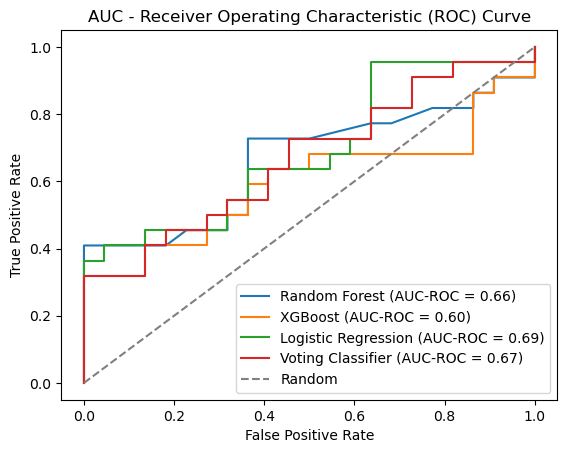

In [3]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Load your data from a CSV file
df_resampled_train_1 = pd.read_csv('C:/Users/User/Downloads/WQD7002 Data Science Research Project/datasets/same_months/testing/test/output_test/run0901/oversampled_normalized_ML_COVID_train_testset.csv')

# Separate features (X) and target variable (y) for training dataset
X_train = df_resampled_train_1.drop('Neuropsychiatric symptoms-new', axis=1)
y_train = df_resampled_train_1['Neuropsychiatric symptoms-new']

# Define class weights (you can adjust these values based on your dataset characteristics)
class_weights = {0: 1, 1: 3}  # Assign higher weight to the minority class

# Initialize individual classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=14, class_weight=class_weights)
xgb_classifier = XGBClassifier(random_state=14, scale_pos_weight=class_weights[1])  # XGBoost uses `scale_pos_weight` for class weights)
logreg_classifier = LogisticRegression(random_state=14, class_weight=class_weights)
voting_classifier = VotingClassifier(estimators=[
    ('random_forest', rf_classifier),
    ('xgboost', xgb_classifier),
    ('logistic_regression', logreg_classifier)
], voting='soft')  # 'hard' means majority voting, you can also use 'soft' for weighted voting

# List of models and their names
models = [rf_classifier, xgb_classifier, logreg_classifier, voting_classifier]
model_names = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Voting Classifier']

# Step 4: Combine oversampled data and perform 5-fold cross-validation for each model
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=16)

# Using F1 score, AUC-ROC, and AUC-PR as the scoring metrics
results_df = pd.DataFrame(columns=['Model', 'Mean F1 Score', 'Mean AUC-ROC', 'Mean AUC-PR'])

for model, name in zip(models, model_names):
    f1_scorer = make_scorer(f1_score)
    auc_roc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    auc_pr_scorer = make_scorer(average_precision_score, needs_proba=True)
    
    # F1 score
    cross_val_results_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_scorer)
    mean_f1_score = cross_val_results_f1.mean()
    
    # AUC-ROC
    cross_val_results_roc = cross_val_score(model, X_train, y_train, cv=cv, scoring=auc_roc_scorer)
    mean_auc_roc = cross_val_results_roc.mean()
    
    # AUC-PR
    cross_val_results_pr = cross_val_score(model, X_train, y_train, cv=cv, scoring=auc_pr_scorer)
    mean_auc_pr = cross_val_results_pr.mean()

    results_df = results_df.append({'Model': name, 'Mean F1 Score': mean_f1_score, 'Mean AUC-ROC': mean_auc_roc, 'Mean AUC-PR': mean_auc_pr}, ignore_index=True)

# Print results
print("\nCross-Validation Results:")
print(results_df)

auc_roc_scores = []
auc_pr_scores = []

# Step 5: Train each model on the entire oversampled training set and test on the test set
results_test_df = pd.DataFrame(columns=['Model', 'Test F1 Score', 'AUC-ROC', 'AUC-PR'])

for model, name in zip(models, model_names):
    # Train the model on the entire oversampled training set
    model.fit(X_train, y_train)
    
    # Predict probabilities on the validation set
    y_prob_test = model.predict_proba(X_test)[:, 1]
    
    # Set a custom threshold 
    custom_threshold = 0.48
    
    # Convert probabilities to binary predictions based on the custom threshold
    y_pred_test_custom = (y_prob_test > custom_threshold).astype(int)
    
    # Evaluate the model with the custom threshold
    f1_test = f1_score(y_test, y_pred_test_custom)
    auc_roc_test_value = roc_auc_score(y_test, y_prob_test)
    auc_pr_test_value = average_precision_score(y_test, y_prob_test)
    
    results_test_df = results_test_df.append({'Model': name, 'Test F1 Score': f1_test, 'AUC-ROC': auc_roc_test_value, 'AUC-PR': auc_pr_test_value}, ignore_index=True)
    
    # Calculate AUC-ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob_test)
    auc_roc = auc(fpr, tpr)
    auc_roc_scores.append((name, auc_roc))

    # Plot AUC-ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC-ROC = {auc_roc:.2f})')
    
# Print results on the test set in descending order of AUC-ROC
results_test_df_sorted = results_test_df.sort_values(by='AUC-ROC', ascending=False)
print("\nTest Set Results (Sorted by AUC-ROC):")
print(results_test_df_sorted)

# Plot Random line for reference
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random')
plt.title('AUC - Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [4]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.linear_model import LogisticRegression

# Load your data from a CSV file
df_resampled_train_1 = pd.read_csv('C:/Users/User/Downloads/WQD7002 Data Science Research Project/datasets/same_months/testing/test/output_test/run0901/oversampled_normalized_ML_COVID_train_testset.csv')

# Separate features (X) and target variable (y) for training dataset
X_train = df_resampled_train_1.drop('Neuropsychiatric symptoms-new', axis=1)
y_train = df_resampled_train_1['Neuropsychiatric symptoms-new']

# Define class weights (you can adjust these values based on your dataset characteristics)
class_weights = {0: 1, 1: 3}  # Assign higher weight to the minority class

# Initialize Logistic Regression classifier
logreg_classifier = LogisticRegression(random_state=14, class_weight=class_weights)

# Step 4: Cross-validation for Logistic Regression
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=16)

# Using F1 score as the scoring metric
f1_scorer = make_scorer(f1_score)
cross_val_results = cross_val_score(logreg_classifier, X_train, y_train, cv=cv, scoring=f1_scorer)
mean_f1_score_cv = cross_val_results.mean()

print("\nCross-Validation F1 Score for Logistic Regression:", mean_f1_score_cv)

# Step 5: Train Logistic Regression on the entire oversampled training set and evaluate on the test set
logreg_classifier.fit(X_train, y_train)

# Predict probabilities on the test set
y_prob_test = logreg_classifier.predict_proba(X_test)[:, 1]

# Set a custom threshold 
custom_threshold = 0.48

# Convert probabilities to binary predictions based on the custom threshold
y_pred_test_custom = (y_prob_test > custom_threshold).astype(int)

# Evaluate the model with the custom threshold on the test set
f1_test = f1_score(y_test, y_pred_test_custom)
print("\nTest F1 Score for Logistic Regression:", f1_test)

# Evaluate the model precision score with the custom threshold on the test set
precision_lr = precision_score(y_test, y_pred_test_custom)
print("\nTest Precision for Logistic Regression:", precision_lr)

# Evaluate the model recall score with the custom threshold on the test set
recall = recall_score(y_test, y_pred_test_custom)
print("\nTest Recall for Logistic Regression:", recall)

# Evaluate the model with the custom threshold on the test set
accuracy = accuracy_score(y_test, y_pred_test_custom)
print("\nTest Accuracy for Logistic Regression:", accuracy)

# Display classification report and confusion matrix
print("\nClassification Report for Logistic Regression on Test Set:")
print(classification_report(y_test, y_pred_test_custom))

print("\nConfusion Matrix for Logistic Regression on Test Set:")
print(confusion_matrix(y_test, y_pred_test_custom))


Cross-Validation F1 Score for Logistic Regression: 0.7096938747420836

Test F1 Score for Logistic Regression: 0.7368421052631579

Test Precision for Logistic Regression: 0.6

Test Recall for Logistic Regression: 0.9545454545454546

Test Accuracy for Logistic Regression: 0.6590909090909091

Classification Report for Logistic Regression on Test Set:
              precision    recall  f1-score   support

           0       0.89      0.36      0.52        22
           1       0.60      0.95      0.74        22

    accuracy                           0.66        44
   macro avg       0.74      0.66      0.63        44
weighted avg       0.74      0.66      0.63        44


Confusion Matrix for Logistic Regression on Test Set:
[[ 8 14]
 [ 1 21]]


In [10]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.linear_model import LogisticRegression

# Load your data from a CSV file
df_resampled_train_1 = pd.read_csv('C:/Users/User/Downloads/WQD7002 Data Science Research Project/datasets/same_months/testing/test/output_test/run0901/oversampled_normalized_ML_COVID_train_testset.csv')

# Separate features (X) and target variable (y) for training dataset
X_train = df_resampled_train_1.drop('Neuropsychiatric symptoms-new', axis=1)
y_train = df_resampled_train_1['Neuropsychiatric symptoms-new']

# Define class weights (you can adjust these values based on your dataset characteristics)
class_weights = {0: 1, 1: 3}  # Assign higher weight to the minority class

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=14, class_weight=class_weights)

# Step 4: Cross-validation for Random Forest
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=16)

# Using F1 score as the scoring metric
f1_scorer = make_scorer(f1_score)
cross_val_results = cross_val_score(rf_classifier, X_train, y_train, cv=cv, scoring=f1_scorer)
mean_f1_score_cv = cross_val_results.mean()

print("\nCross-Validation F1 Score for Random Forest:", mean_f1_score_cv)

# Step 5: Train Random Forest on the entire oversampled training set and evaluate on the test set
rf_classifier.fit(X_train, y_train)

# Predict probabilities on the test set
y_prob_test = rf_classifier.predict_proba(X_test)[:, 1]

# Set a custom threshold 
custom_threshold = 0.48

# Convert probabilities to binary predictions based on the custom threshold
y_pred_test_custom = (y_prob_test > custom_threshold).astype(int)

# Evaluate the model with the custom threshold on the test set
f1_test = f1_score(y_test, y_pred_test_custom)
print("\nTest F1 Score for Random Forest:", f1_test)

# Evaluate the model precision score with the custom threshold on the test set
precision_rf = precision_score(y_test, y_pred_test_custom)
print("\nTest Precision for Random Forest:", precision_rf)

# Evaluate the model recall score with the custom threshold on the test set
recall_rf = recall_score(y_test, y_pred_test_custom)
print("\nTest Recall for Random Forest:", recall_rf)

# Evaluate the model with the custom threshold on the test set
accuracy_rf = accuracy_score(y_test, y_pred_test_custom)
print("\nTest Accuracy for Random Forest:", accuracy_rf)

# Display classification report and confusion matrix
print("\nClassification Report for Random Forest on Test Set:")
print(classification_report(y_test, y_pred_test_custom))

print("\nConfusion Matrix for Random Forest on Test Set:")
print(confusion_matrix(y_test, y_pred_test_custom))


Cross-Validation F1 Score for Random Forest: 0.9256552101098408

Test F1 Score for Random Forest: 0.5806451612903226

Test Precision for Random Forest: 1.0

Test Recall for Random Forest: 0.4090909090909091

Test Accuracy for Random Forest: 0.7045454545454546

Classification Report for Random Forest on Test Set:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77        22
           1       1.00      0.41      0.58        22

    accuracy                           0.70        44
   macro avg       0.81      0.70      0.68        44
weighted avg       0.81      0.70      0.68        44


Confusion Matrix for Random Forest on Test Set:
[[22  0]
 [13  9]]


In [9]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.linear_model import LogisticRegression

# Load your data from a CSV file
df_resampled_train_1 = pd.read_csv('C:/Users/User/Downloads/WQD7002 Data Science Research Project/datasets/same_months/testing/test/output_test/run0901/oversampled_normalized_ML_COVID_train_testset.csv')

# Separate features (X) and target variable (y) for training dataset
X_train = df_resampled_train_1.drop('Neuropsychiatric symptoms-new', axis=1)
y_train = df_resampled_train_1['Neuropsychiatric symptoms-new']

# Define class weights (you can adjust these values based on your dataset characteristics)
class_weights = {0: 1, 1: 3}  # Assign higher weight to the minority class

# Initialize XGBoost classifier
xgb_classifier = XGBClassifier(random_state=14, scale_pos_weight=class_weights[1])

# Step 4: Cross-validation for XGBoost
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=16)

# Using F1 score as the scoring metric
f1_scorer = make_scorer(f1_score)
cross_val_results = cross_val_score(xgb_classifier, X_train, y_train, cv=cv, scoring=f1_scorer)
mean_f1_score_cv = cross_val_results.mean()

print("\nCross-Validation F1 Score for XGBoost:", mean_f1_score_cv)

# Step 5: Train XGBoost on the entire oversampled training set and evaluate on the test set
xgb_classifier.fit(X_train, y_train)

# Predict probabilities on the test set
y_prob_test = xgb_classifier.predict_proba(X_test)[:, 1]

# Set a custom threshold 
custom_threshold = 0.48

# Convert probabilities to binary predictions based on the custom threshold
y_pred_test_custom = (y_prob_test > custom_threshold).astype(int)

# Evaluate the model with the custom threshold on the test set
f1_test = f1_score(y_test, y_pred_test_custom)
print("\nTest F1 Score for XGBoost:", f1_test)

# Evaluate the model precision score with the custom threshold on the test set
precision_xg = precision_score(y_test, y_pred_test_custom)
print("\nTest Precision for XGBoost:", precision_xg)

# Evaluate the model recall score with the custom threshold on the test set
recall_xg = recall_score(y_test, y_pred_test_custom)
print("\nTest Recall for XGBoost:", recall_xg)

# Evaluate the model with the custom threshold on the test set
accuracy_xg = accuracy_score(y_test, y_pred_test_custom)
print("\nTest Accuracy for XGBoost:", accuracy_xg)

# Display classification report and confusion matrix
print("\nClassification Report for XGBoost on Test Set:")
print(classification_report(y_test, y_pred_test_custom))

print("\nConfusion Matrix for XGBoost on Test Set:")
print(confusion_matrix(y_test, y_pred_test_custom))


Cross-Validation F1 Score for XGBoost: 0.9085400795499364

Test F1 Score for XGBoost: 0.5294117647058824

Test Precision for XGBoost: 0.75

Test Recall for XGBoost: 0.4090909090909091

Test Accuracy for XGBoost: 0.6363636363636364

Classification Report for XGBoost on Test Set:
              precision    recall  f1-score   support

           0       0.59      0.86      0.70        22
           1       0.75      0.41      0.53        22

    accuracy                           0.64        44
   macro avg       0.67      0.64      0.62        44
weighted avg       0.67      0.64      0.62        44


Confusion Matrix for XGBoost on Test Set:
[[19  3]
 [13  9]]


In [8]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.linear_model import LogisticRegression

# Load your data from a CSV file
df_resampled_train_1 = pd.read_csv('C:/Users/User/Downloads/WQD7002 Data Science Research Project/datasets/same_months/testing/test/output_test/run0901/oversampled_normalized_ML_COVID_train_testset.csv')

# Separate features (X) and target variable (y) for training dataset
X_train = df_resampled_train_1.drop('Neuropsychiatric symptoms-new', axis=1)
y_train = df_resampled_train_1['Neuropsychiatric symptoms-new']

# Define class weights (you can adjust these values based on your dataset characteristics)
class_weights = {0: 1, 1: 3}  # Assign higher weight to the minority class

# Initialize Voting Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=14, class_weight=class_weights)
xgb_classifier = XGBClassifier(random_state=14, scale_pos_weight=class_weights[1])
logreg_classifier = LogisticRegression(random_state=14, class_weight=class_weights)
voting_classifier = VotingClassifier(estimators=[
    ('random_forest', rf_classifier),
    ('xgboost', xgb_classifier),
    ('logistic_regression', logreg_classifier)
], voting='soft')

# Step 4: Cross-validation for Voting Classifier
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=16)

# Using F1 score as the scoring metric
f1_scorer = make_scorer(f1_score)
cross_val_results = cross_val_score(voting_classifier, X_train, y_train, cv=cv, scoring=f1_scorer)
mean_f1_score_cv = cross_val_results.mean()

print("\nCross-Validation F1 Score for Voting Classifier:", mean_f1_score_cv)

# Step 5: Train Voting Classifier on the entire oversampled training set and evaluate on the test set
voting_classifier.fit(X_train, y_train)

# Predict probabilities on the test set
y_prob_test = voting_classifier.predict_proba(X_test)[:, 1]

# Set a custom threshold 
custom_threshold = 0.48

# Convert probabilities to binary predictions based on the custom threshold
y_pred_test_custom = (y_prob_test > custom_threshold).astype(int)

# Evaluate the model with the custom threshold on the test set
f1_test = f1_score(y_test, y_pred_test_custom)
print("\nTest F1 Score for Voting Classifier:", f1_test)

# Evaluate the model precision score with the custom threshold on the test set
precision_vc = precision_score(y_test, y_pred_test_custom)
print("\nTest Precision for Voting Classifier:", precision_vc)

# Evaluate the model recall score with the custom threshold on the test set
recall_vc = recall_score(y_test, y_pred_test_custom)
print("\nTest Recall for Voting Classifier:", recall_vc)

# Evaluate the model accuracy with the custom threshold on the test set
accuracy_vc = accuracy_score(y_test, y_pred_test_custom)
print("\nTest Accuracy for Voting Classifier:", accuracy_vc)

# Display classification report and confusion matrix
print("\nClassification Report for Voting Classifier on Test Set:")
print(classification_report(y_test, y_pred_test_custom))

print("\nConfusion Matrix for Voting Classifier on Test Set:")
print(confusion_matrix(y_test, y_pred_test_custom))


Cross-Validation F1 Score for Voting Classifier: 0.9060863516921783

Test F1 Score for Voting Classifier: 0.5142857142857142

Test Precision for Voting Classifier: 0.6923076923076923

Test Recall for Voting Classifier: 0.4090909090909091

Test Accuracy for Voting Classifier: 0.6136363636363636

Classification Report for Voting Classifier on Test Set:
              precision    recall  f1-score   support

           0       0.58      0.82      0.68        22
           1       0.69      0.41      0.51        22

    accuracy                           0.61        44
   macro avg       0.64      0.61      0.60        44
weighted avg       0.64      0.61      0.60        44


Confusion Matrix for Voting Classifier on Test Set:
[[18  4]
 [13  9]]


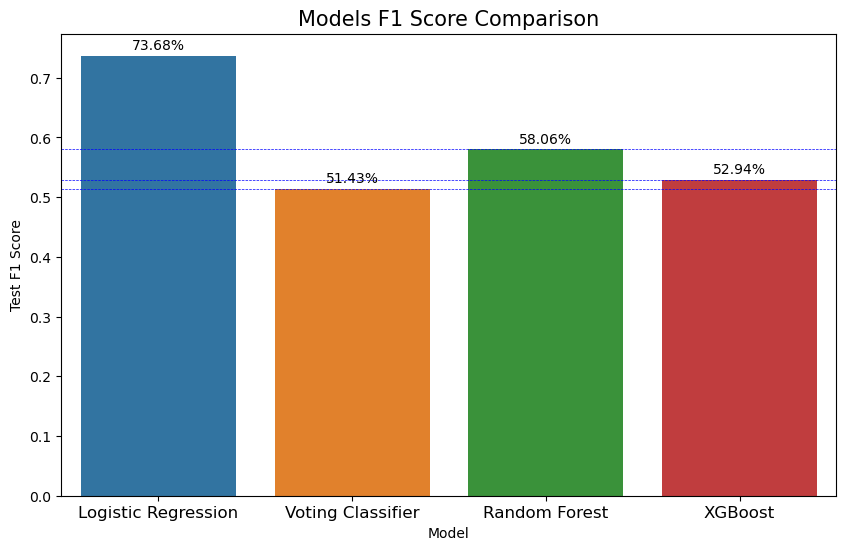

In [19]:
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns

# Create a bar chart
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=results_test_df_sorted["Model"], y=results_test_df_sorted["Test F1 Score"])

# Add lines connecting each bar to the y-axis and display values on top as percentages
for index, value in enumerate(results_test_df_sorted["Test F1 Score"]):
    plt.text(index, value + 0.01, f'{value:.2%}', ha='center')  # Display value on top of each bar in percentage
    plt.axhline(y=value, xmax=index, color='blue', linestyle='--', linewidth=0.5)  # Vertical dashed line to y-axis
#     plt.hlines(y=value, xmin=-0.4, xmax=index, colors='blue', linestyle='--', linewidth=0.5)  # Line connecting bar to y-axis

plt.title("Models F1 Score Comparison", size=15)
plt.xticks(rotation=0, size=12)
plt.show()


Cross-Validation Results:
                 Model  Mean F1 Score  Mean AUC-ROC  Mean AUC-PR
0        Random Forest       0.925655      0.966124     0.962337
1              XGBoost       0.908540      0.964267     0.965299
2  Logistic Regression       0.709694      0.778670     0.788441
3    Voting Classifier       0.906086      0.963013     0.958311

Test Set Results (Sorted by AUC-ROC):
                 Model  Test F1 Score   AUC-ROC    AUC-PR
2  Logistic Regression       0.736842  0.688017  0.756795
3    Voting Classifier       0.514286  0.667355  0.733316
0        Random Forest       0.580645  0.663223  0.752364
1              XGBoost       0.529412  0.597107  0.705558

AUC-PR Scores:
Random Forest: 0.7483
XGBoost: 0.6995
Logistic Regression: 0.7518
Voting Classifier: 0.7273


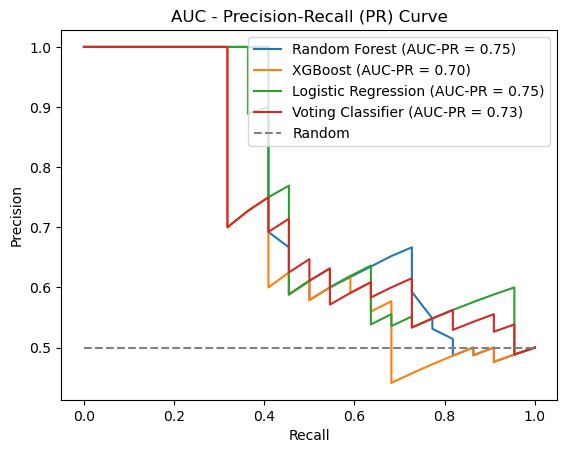

In [83]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Load your data from a CSV file
df_resampled_train_1 = pd.read_csv('C:/Users/User/Downloads/WQD7002 Data Science Research Project/datasets/same_months/testing/test/output_test/run0901/oversampled_normalized_ML_COVID_train_testset.csv')

# Separate features (X) and target variable (y) for training dataset
X_train = df_resampled_train_1.drop('Neuropsychiatric symptoms-new', axis=1)
y_train = df_resampled_train_1['Neuropsychiatric symptoms-new']

# Define class weights (you can adjust these values based on your dataset characteristics)
class_weights = {0: 1, 1: 3}  # Assign higher weight to the minority class

# Initialize individual classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=14, class_weight=class_weights)
xgb_classifier = XGBClassifier(random_state=14, scale_pos_weight=class_weights[1])  # XGBoost uses `scale_pos_weight` for class weights)
logreg_classifier = LogisticRegression(random_state=14, class_weight=class_weights)
voting_classifier = VotingClassifier(estimators=[
    ('random_forest', rf_classifier),
    ('xgboost', xgb_classifier),
    ('logistic_regression', logreg_classifier)
], voting='soft')  # 'hard' means majority voting, you can also use 'soft' for weighted voting

# List of models and their names
models = [rf_classifier, xgb_classifier, logreg_classifier, voting_classifier]
model_names = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Voting Classifier']

# Step 4: Combine oversampled data and perform 5-fold cross-validation for each model
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=16)

# Using F1 score, AUC-ROC, and AUC-PR as the scoring metrics
results_df = pd.DataFrame(columns=['Model', 'Mean F1 Score', 'Mean AUC-ROC', 'Mean AUC-PR'])

for model, name in zip(models, model_names):
    f1_scorer = make_scorer(f1_score)
    auc_roc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    auc_pr_scorer = make_scorer(average_precision_score, needs_proba=True)
    
    # F1 score
    cross_val_results_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_scorer)
    mean_f1_score = cross_val_results_f1.mean()
    
    # AUC-ROC
    cross_val_results_roc = cross_val_score(model, X_train, y_train, cv=cv, scoring=auc_roc_scorer)
    mean_auc_roc = cross_val_results_roc.mean()
    
    # AUC-PR
    cross_val_results_pr = cross_val_score(model, X_train, y_train, cv=cv, scoring=auc_pr_scorer)
    mean_auc_pr = cross_val_results_pr.mean()

    results_df = results_df.append({'Model': name, 'Mean F1 Score': mean_f1_score, 'Mean AUC-ROC': mean_auc_roc, 'Mean AUC-PR': mean_auc_pr}, ignore_index=True)

# Print results
print("\nCross-Validation Results:")
print(results_df)

auc_roc_scores = []
auc_pr_scores = []

# Step 5: Train each model on the entire oversampled training set and test on the test set
results_test_df = pd.DataFrame(columns=['Model', 'Test F1 Score', 'AUC-ROC', 'AUC-PR'])

for model, name in zip(models, model_names):
    # Train the model on the entire oversampled training set
    model.fit(X_train, y_train)
    
    # Predict probabilities on the validation set
    y_prob_test = model.predict_proba(X_test)[:, 1]
    
    # Set a custom threshold 
    custom_threshold = 0.48
    
    # Convert probabilities to binary predictions based on the custom threshold
    y_pred_test_custom = (y_prob_test > custom_threshold).astype(int)
    
    # Evaluate the model with the custom threshold
    f1_test = f1_score(y_test, y_pred_test_custom)
    auc_roc_test_value = roc_auc_score(y_test, y_prob_test)
    auc_pr_test_value = average_precision_score(y_test, y_prob_test)
    
    results_test_df = results_test_df.append({'Model': name, 'Test F1 Score': f1_test, 'AUC-ROC': auc_roc_test_value, 'AUC-PR': auc_pr_test_value}, ignore_index=True)
    
    # Calculate Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob_test)
    
    # Calculate AUC-PR
    auc_pr = auc(recall, precision)
    auc_pr_scores.append((name, auc_pr))

    # Plot Precision-Recall curve
    plt.plot(recall, precision, label=f'{name} (AUC-PR = {auc_pr:.2f})')
    
# Print results on the test set in descending order of AUC-ROC
results_test_df_sorted = results_test_df.sort_values(by='AUC-ROC', ascending=False)
print("\nTest Set Results (Sorted by AUC-ROC):")
print(results_test_df_sorted)

# Print AUC-PR scores
print("\nAUC-PR Scores:")
for name, score in auc_pr_scores:
    print(f'{name}: {score:.4f}')

# Plot Random line for reference
plt.plot([0, 1], [sum(y_test) / len(y_test)] * 2, linestyle='--', color='grey', label='Random')
plt.title('AUC - Precision-Recall (PR) Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()



Cross-Validation Results:
                 Model  Mean F1 Score  Mean AUC-ROC  Mean AUC-PR
0        Random Forest       0.925655      0.966124     0.962337
1              XGBoost       0.908540      0.964267     0.965299
2  Logistic Regression       0.709694      0.778670     0.788441
3    Voting Classifier       0.906086      0.963013     0.958311


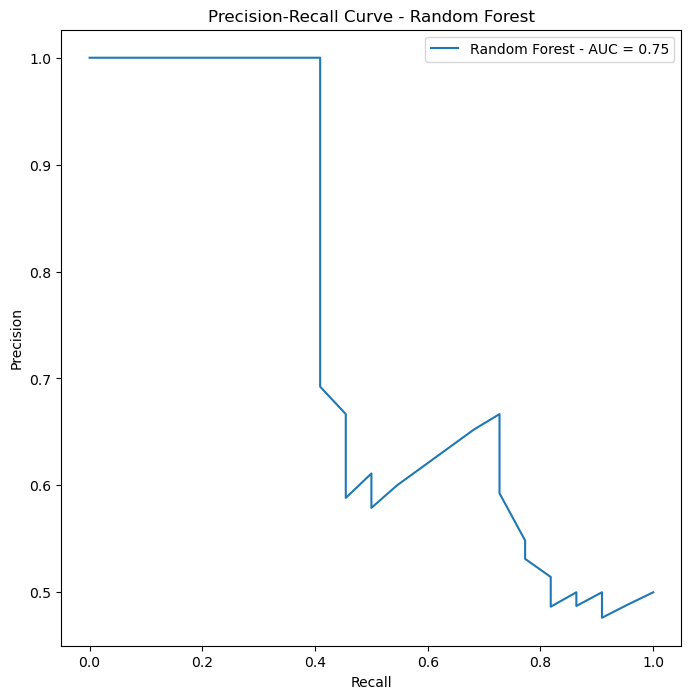

Best Threshold for Random Forest: 0.18


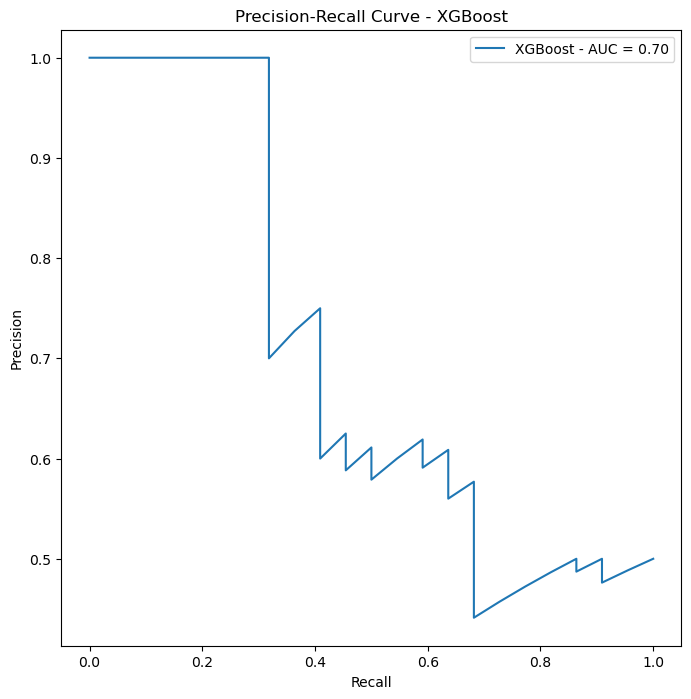

Best Threshold for XGBoost: 6.274651241255924e-05


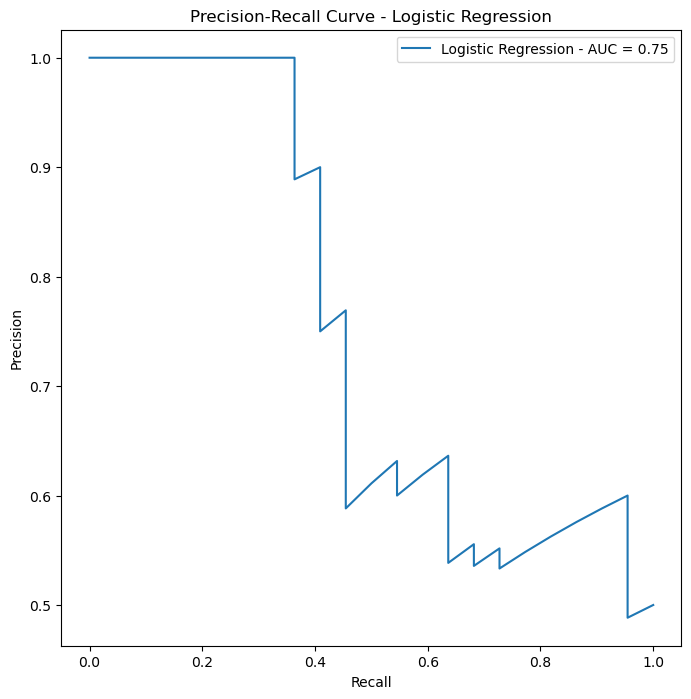

Best Threshold for Logistic Regression: 0.48318794131602083


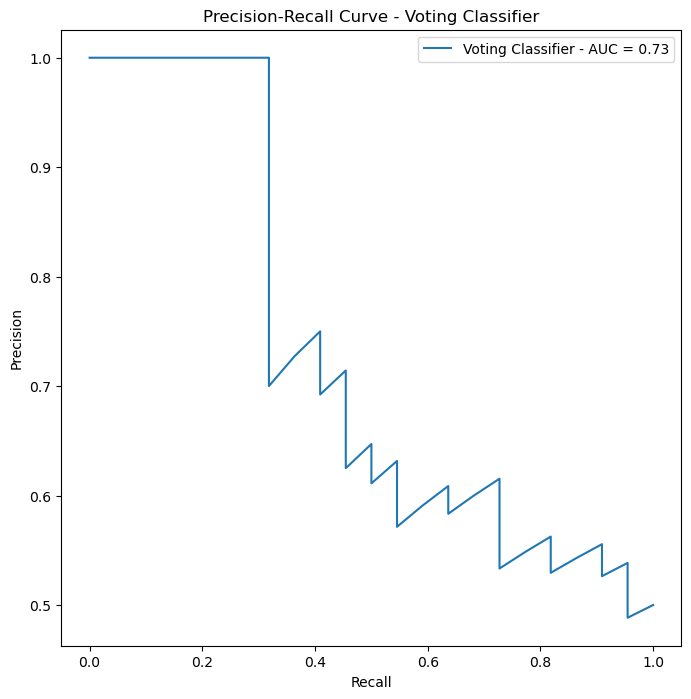

Best Threshold for Voting Classifier: 0.19942840056694425


In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Load your data from a CSV file
df_resampled_train_1 = pd.read_csv('C:/Users/User/Downloads/WQD7002 Data Science Research Project/datasets/same_months/testing/test/output_test/run0901/oversampled_normalized_ML_COVID_train_testset.csv')

# Separate features (X) and target variable (y) for training dataset
X_train = df_resampled_train_1.drop('Neuropsychiatric symptoms-new', axis=1)
y_train = df_resampled_train_1['Neuropsychiatric symptoms-new']

# Define class weights (you can adjust these values based on your dataset characteristics)
class_weights = {0: 1, 1: 3}  # Assign higher weight to the minority class

# Initialize individual classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=14, class_weight=class_weights)
xgb_classifier = XGBClassifier(random_state=14, scale_pos_weight=class_weights[1])  # XGBoost uses `scale_pos_weight` for class weights)
logreg_classifier = LogisticRegression(random_state=14, class_weight=class_weights)
voting_classifier = VotingClassifier(estimators=[
    ('random_forest', rf_classifier),
    ('xgboost', xgb_classifier),
    ('logistic_regression', logreg_classifier)
], voting='soft')  # 'hard' means majority voting, you can also use 'soft' for weighted voting

# List of models and their names
models = [rf_classifier, xgb_classifier, logreg_classifier, voting_classifier]
model_names = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Voting Classifier']

# Step 4: Combine oversampled data and perform 5-fold cross-validation for each model
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=16)

# Using F1 score, AUC-ROC, and AUC-PR as the scoring metrics
results_df = pd.DataFrame(columns=['Model', 'Mean F1 Score', 'Mean AUC-ROC', 'Mean AUC-PR'])

for model, name in zip(models, model_names):
    f1_scorer = make_scorer(f1_score)
    auc_roc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    auc_pr_scorer = make_scorer(average_precision_score, needs_proba=True)
    
    # F1 score
    cross_val_results_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_scorer)
    mean_f1_score = cross_val_results_f1.mean()
    
    # AUC-ROC
    cross_val_results_roc = cross_val_score(model, X_train, y_train, cv=cv, scoring=auc_roc_scorer)
    mean_auc_roc = cross_val_results_roc.mean()
    
    # AUC-PR
    cross_val_results_pr = cross_val_score(model, X_train, y_train, cv=cv, scoring=auc_pr_scorer)
    mean_auc_pr = cross_val_results_pr.mean()

    results_df = results_df.append({'Model': name, 'Mean F1 Score': mean_f1_score, 'Mean AUC-ROC': mean_auc_roc, 'Mean AUC-PR': mean_auc_pr}, ignore_index=True)

# Print results
print("\nCross-Validation Results:")
print(results_df)

for model, name in zip(models, model_names):
    # Train the model on the entire oversampled training set
    model.fit(X_train, y_train)
    
    # Predict probabilities on the test set
    y_prob_test = model.predict_proba(X_test)[:, 1]

    # Calculate Precision-Recall curve
    precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob_test)

    # Find the threshold that maximizes the F1 score
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds_pr[np.argmax(f1_scores)]

    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 8))
    plt.plot(recall, precision, label=f'{name} - AUC = {auc(recall, precision):.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {name}')
    plt.legend()
    plt.show()

    print(f'Best Threshold for {name}: {best_threshold}')



Cross-Validation Results:
                 Model  Mean F1 Score  Mean AUC-ROC  Mean AUC-PR
0        Random Forest       0.925655      0.966124     0.962337
1              XGBoost       0.908540      0.964267     0.965299
2  Logistic Regression       0.709694      0.778670     0.788441
3    Voting Classifier       0.906086      0.963013     0.958311


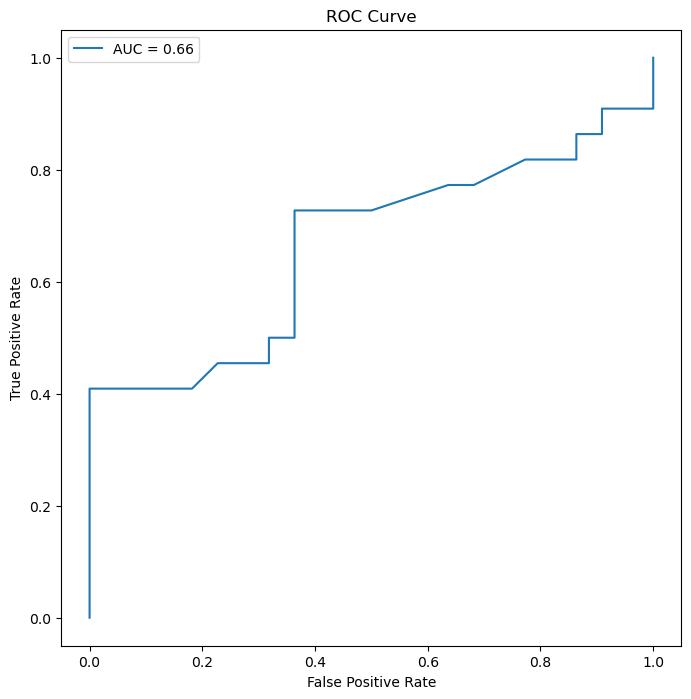

Best Threshold for Random Forest: 0.18


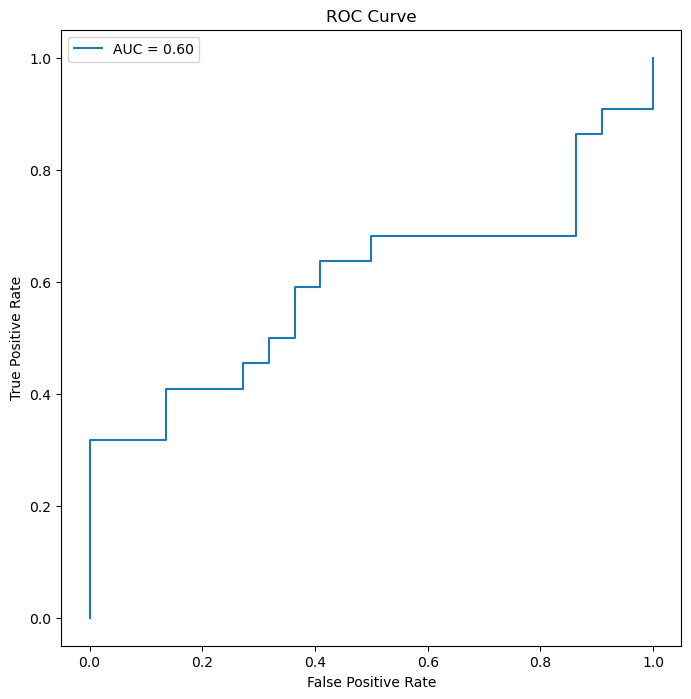

Best Threshold for XGBoost: 6.274651241255924e-05


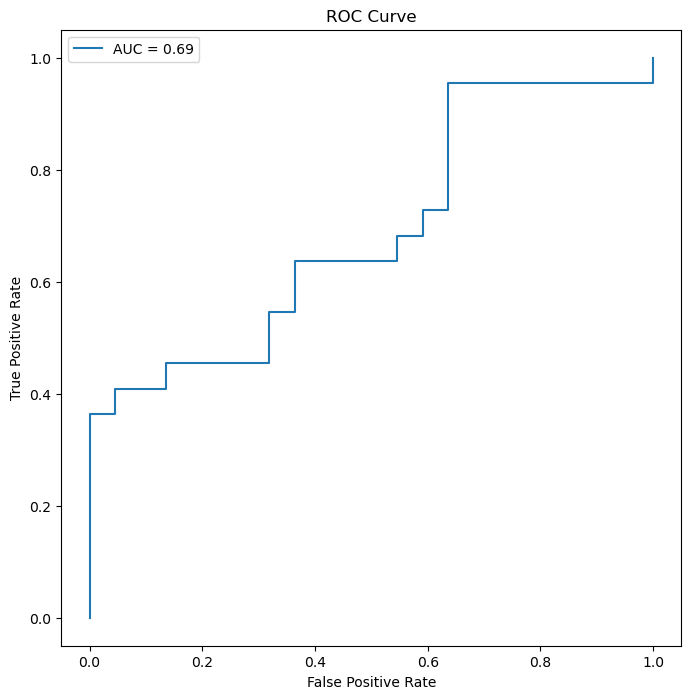

Best Threshold for Logistic Regression: 0.48318794131602083


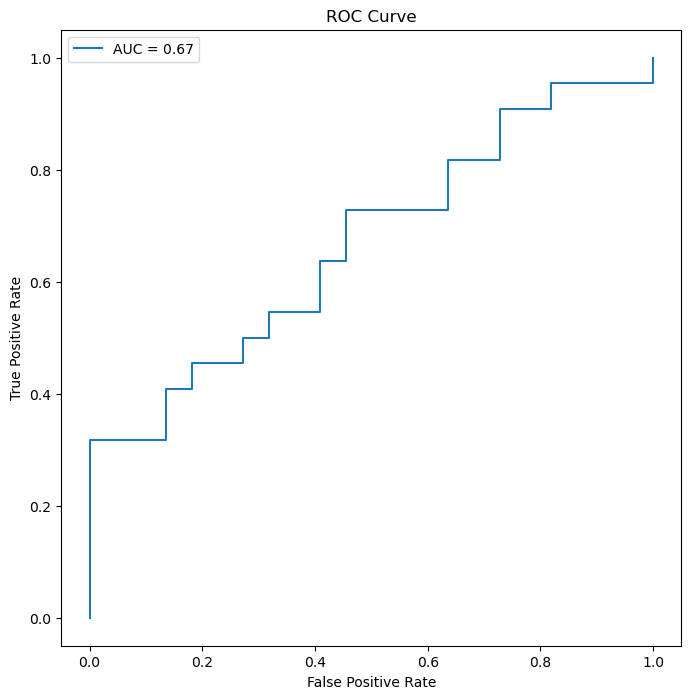

Best Threshold for Voting Classifier: 0.19942840056694425


In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Load your data from a CSV file
df_resampled_train_1 = pd.read_csv('C:/Users/User/Downloads/WQD7002 Data Science Research Project/datasets/same_months/testing/test/output_test/run0901/oversampled_normalized_ML_COVID_train_testset.csv')

# Separate features (X) and target variable (y) for training dataset
X_train = df_resampled_train_1.drop('Neuropsychiatric symptoms-new', axis=1)
y_train = df_resampled_train_1['Neuropsychiatric symptoms-new']

# Define class weights (you can adjust these values based on your dataset characteristics)
class_weights = {0: 1, 1: 3}  # Assign higher weight to the minority class

# Initialize individual classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=14, class_weight=class_weights)
xgb_classifier = XGBClassifier(random_state=14, scale_pos_weight=class_weights[1])  # XGBoost uses `scale_pos_weight` for class weights)
logreg_classifier = LogisticRegression(random_state=14, class_weight=class_weights)
voting_classifier = VotingClassifier(estimators=[
    ('random_forest', rf_classifier),
    ('xgboost', xgb_classifier),
    ('logistic_regression', logreg_classifier)
], voting='soft')  # 'hard' means majority voting, you can also use 'soft' for weighted voting

# List of models and their names
models = [rf_classifier, xgb_classifier, logreg_classifier, voting_classifier]
model_names = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Voting Classifier']

# Step 4: Combine oversampled data and perform 5-fold cross-validation for each model
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=16)

# Using F1 score, AUC-ROC, and AUC-PR as the scoring metrics
results_df = pd.DataFrame(columns=['Model', 'Mean F1 Score', 'Mean AUC-ROC', 'Mean AUC-PR'])

for model, name in zip(models, model_names):
    f1_scorer = make_scorer(f1_score)
    auc_roc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    auc_pr_scorer = make_scorer(average_precision_score, needs_proba=True)
    
    # F1 score
    cross_val_results_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_scorer)
    mean_f1_score = cross_val_results_f1.mean()
    
    # AUC-ROC
    cross_val_results_roc = cross_val_score(model, X_train, y_train, cv=cv, scoring=auc_roc_scorer)
    mean_auc_roc = cross_val_results_roc.mean()
    
    # AUC-PR
    cross_val_results_pr = cross_val_score(model, X_train, y_train, cv=cv, scoring=auc_pr_scorer)
    mean_auc_pr = cross_val_results_pr.mean()

    results_df = results_df.append({'Model': name, 'Mean F1 Score': mean_f1_score, 'Mean AUC-ROC': mean_auc_roc, 'Mean AUC-PR': mean_auc_pr}, ignore_index=True)

# Print results
print("\nCross-Validation Results:")
print(results_df)

for model, name in zip(models, model_names):
    # Train the model on the entire oversampled training set
    model.fit(X_train, y_train)
    
    # Predict probabilities on the test set
    y_prob_test = model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob_test)

    # Calculate Precision-Recall curve
    precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob_test)

    # Find the threshold that maximizes the F1 score
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds_pr[np.argmax(f1_scores)]

    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    print(f'Best Threshold for {name}: {best_threshold}')


In [20]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

# Load your data from a CSV file
df_resampled_train_1 = pd.read_csv('C:/Users/User/Downloads/WQD7002 Data Science Research Project/datasets/same_months/testing/test/output_test/run0901/oversampled_normalized_ML_COVID_train_testset.csv')

# Separate features (X) and target variable (y) for training dataset
X_train = df_resampled_train_1.drop('Neuropsychiatric symptoms-new', axis=1)
y_train = df_resampled_train_1['Neuropsychiatric symptoms-new']

# Define class weights (you can adjust these values based on your dataset characteristics)
class_weights = {0: 1, 1: 3}  # Assign higher weight to the minority class

# Initialize Logistic Regression classifier
logreg_classifier = LogisticRegression(random_state=14, class_weight=class_weights)

# Step 4: Cross-validation for Logistic Regression
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=16)

# Using F1 score as the scoring metric
f1_scorer = make_scorer(f1_score)
cross_val_results = cross_val_score(logreg_classifier, X_train, y_train, cv=cv, scoring=f1_scorer)
mean_f1_score_cv = cross_val_results.mean()

print("\nCross-Validation F1 Score for Logistic Regression:", mean_f1_score_cv)

# Step 5: Train Logistic Regression on the entire oversampled training set and evaluate on the test set
logreg_classifier.fit(X_train, y_train)

# Predict probabilities on the test set
y_prob_test = logreg_classifier.predict_proba(X_test)[:, 1]

# Set a custom threshold 
custom_threshold = 0.48

# Convert probabilities to binary predictions based on the custom threshold
y_pred_test_custom = (y_prob_test > custom_threshold).astype(int)

# Evaluate the model with the custom threshold on the test set
f1_test = f1_score(y_test, y_pred_test_custom)
print("\nTest F1 Score for Logistic Regression:", f1_test)

# Display classification report and confusion matrix
print("\nClassification Report for Logistic Regression on Test Set:")
print(classification_report(y_test, y_pred_test_custom))

print("\nConfusion Matrix for Logistic Regression on Test Set:")
print(confusion_matrix(y_test, y_pred_test_custom))



Cross-Validation F1 Score for Logistic Regression: 0.7096938747420836

Test F1 Score for Logistic Regression: 0.7368421052631579

Classification Report for Logistic Regression on Test Set:
              precision    recall  f1-score   support

           0       0.89      0.36      0.52        22
           1       0.60      0.95      0.74        22

    accuracy                           0.66        44
   macro avg       0.74      0.66      0.63        44
weighted avg       0.74      0.66      0.63        44


Confusion Matrix for Logistic Regression on Test Set:
[[ 8 14]
 [ 1 21]]


In [22]:
# Get feature importances (coefficients)
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': logreg_classifier.coef_[0]})
feature_importances = feature_importances.sort_values(by='Coefficient', ascending=False)

# Display feature importances
print(feature_importances)

                    Feature  Coefficient
0                    Median     2.699618
2                       Min     2.393310
1                      Mode     0.285452
4           REMTime (hours)    -0.864783
5  shallowSleepTime (hours)    -0.934838
3     deepSleepTime (hours)    -1.168354
